# Chapter 13 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
import h2o
from h2o.automl import H2OAutoML
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import mlba
%matplotlib inline

 
The Python packages xgboost and lightgbm require special libraries to be installed. Follow the instructions on the respective websites to install them.

In [3]:
bank_df = mlba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# split into training and holdout
X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.40,
                                                      random_state=3)

# train decision tree and ensemble models
defaultTree = DecisionTreeClassifier(random_state=1, max_depth=5)
defaultTree.fit(X_train, y_train)

bagging = BaggingClassifier(defaultTree, n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)

boost = AdaBoostClassifier(defaultTree, n_estimators=100, random_state=1, algorithm='SAMME')
boost.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

xgb = XGBClassifier(n_estimators=100, random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [4]:
classes = defaultTree.classes_
models = {
    'Single tree': defaultTree,
    'Bagging': bagging,
    'Boosting': boost,
    'Random Forest': rf,
    'XGBoost': xgb
}
for model_name, model in models.items():
    print(model_name)
    mlba.classificationSummary(y_true=y_holdout, y_pred=model.predict(X_holdout),
        class_names=classes)
    print()

Single tree
Confusion Matrix (Accuracy 0.9765)

       Prediction
Actual    0    1
     0 1782   11
     1   36  171

Bagging
Confusion Matrix (Accuracy 0.9775)

       Prediction
Actual    0    1
     0 1781   12
     1   33  174

Boosting
Confusion Matrix (Accuracy 0.9845)

       Prediction
Actual    0    1
     0 1790    3
     1   28  179

Random Forest
Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1784    9
     1   25  182

XGBoost
Confusion Matrix (Accuracy 0.9815)

       Prediction
Actual    0    1
     0 1777   16
     1   21  186



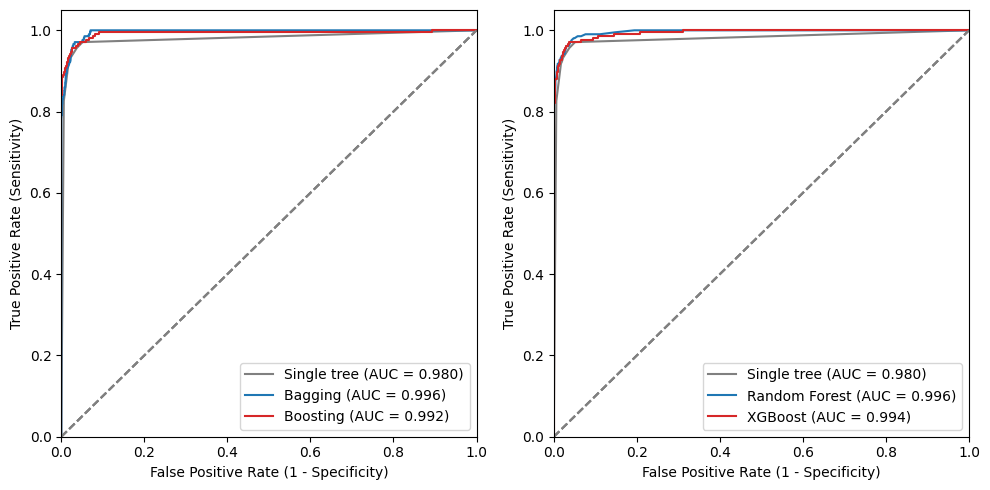

In [5]:
def plot_roc_curve(model, X, y, model_name, pos_label, color=None, ax=None):
    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1], pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        fig, ax = plt.subplots(figsize=[5, 5])
    ax.plot(fpr, tpr, color=color, label=f'{model_name} (AUC = {roc_auc:0.3f})')
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.legend(loc="lower right")
    return ax

fig, axes = plt.subplots(ncols=2, figsize=[10, 5])
plot_roc_curve(defaultTree, X_holdout, y_holdout, 'Single tree', color='grey', pos_label=1, ax=axes[0])
plot_roc_curve(bagging, X_holdout, y_holdout, 'Bagging', color='C0', pos_label=1, ax=axes[0])
plot_roc_curve(boost, X_holdout, y_holdout, 'Boosting', color='C3', pos_label=1, ax=axes[0])
plot_roc_curve(defaultTree, X_holdout, y_holdout, 'Single tree', color='grey', pos_label=1, ax=axes[1])
plot_roc_curve(rf, X_holdout, y_holdout, 'Random Forest', color='C0', pos_label=1, ax=axes[1])
plot_roc_curve(xgb, X_holdout, y_holdout, 'XGBoost', color='C3', pos_label=1, ax=axes[1])
plt.tight_layout()
plt.show()

In [6]:
# load and preprocess the data
bank_df = mlba.load_data('UniversalBank.csv')

# identify outcome and predictors
outcome = 'Personal Loan'
predictors = [c for c in bank_df.columns if c not in (outcome, 'ID', 'ZIP Code')]

# partition the data
# h2o works on the full dataset, so we split the dataset into train and holdout
train, holdout = train_test_split(bank_df, test_size=0.4, random_state=1)

In [7]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321.

 connected.


H2O_cluster_uptime:,15 hours 22 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_petergedeck_l9jxu3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,19.95 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"locked, healthy"


In [8]:
h2o.no_progress()

In [9]:
train_h2o = h2o.H2OFrame(train)
holdout_h2o = h2o.H2OFrame(holdout)
train_h2o[outcome] = train_h2o[outcome].asfactor()
holdout_h2o[outcome] = holdout_h2o[outcome].asfactor()

In [10]:
aml = H2OAutoML(max_models=20, exclude_algos=['DeepLearning'], seed=1)
aml.train(x=predictors, y=outcome, training_frame=train_h2o)


08:50:28.875: AutoML: XGBoost is not available; skipping it.



Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_24_20240909_85028_model_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    85                 85                          20952                  4            4            4             12            16            15.0118

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0011439887944862208
RMSE: 0.03382290340118986
LogLoss: 0.007260014540309109
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3485590666264635
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      2713  0    0        (0.0/2713.0)
1      0     287  0        (0.0/287.0)
Total  2713  287  0        (0.0/3000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348559     1         154
max f2                       0.348559     1         154
max f0point5                 0.348559     1         154
max accuracy                 0.348559     1         154
max precision                0.999614     1         0
max recall                   0.348559     1         154
max specificity              0.999614     1         0
max absolute_mcc             0.348559     1         154
max min_per_class_accuracy   0.348559     1         154
max mean_per_class_accuracy  0.348559     1         154
max tns                      0.999614     2713      0
max fns                      0.999614     285       0
max fps                      0.000167915  2713      399
max tps                      0.348559     287       154
max tnr                      0.999614     1         0
max fnr                      0.999614     0.993031  0
max fpr                      0.000167915  1         399
max tpr                      0.348559     1         154

Gains/Lift Table: Avg response rate:  9.57 %, avg score:  9.55 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.01                        0.998677           10.453   10.453             1                0.998995     1                           0.998995            0.10453         0.10453                    945.296  945.296            0.10453
2        0.02                        0.997953           10.453   10.453             1                0.9983       1                           0.998647            0.10453         0.209059                   945.296  945.296            0.209059
3        0.03                        0.996968           10.453   10.453             1                0.997556     1                           0.998284            0.10453         0.313589                   945.296  945.296            0.313589
4        0.04                        0.995958           10.453   10.453             1                0.996518     1                           0.997842            0.10453         0.418118                   945.296  945.296            0.418118
5        0.05                        0.994806           10.453   10.453             1                0.995401     1                           0.997354            0.10453         0.522648                   94

In [11]:
aml_balanced = H2OAutoML(max_models=20, exclude_algos=['DeepLearning'], seed=1,
                         balance_classes=True)
aml_balanced.train(x=predictors, y=outcome, training_frame=train_h2o)


08:50:43.227: AutoML: XGBoost is not available; skipping it.



Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_25_20240909_85043_model_12


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    65                 65                          69386                  7            7            7             37            102           80.3385

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.00035971366759035355
RMSE: 0.018966118938527027
LogLoss: 0.008114582025818511
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.785903946046922
       0     1     Error    Rate
-----  ----  ----  -------  ------------
0      2713  0     0        (0.0/2713.0)
1      0     2722  0        (0.0/2722.0)
Total  2713  2722  0        (0.0/5435.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.785904     1         249
max f2                       0.785904     1         249
max f0point5                 0.785904     1         249
max accuracy                 0.785904     1         249
max precision                0.993131     1         0
max recall                   0.785904     1         249
max specificity              0.993131     1         0
max absolute_mcc             0.785904     1         249
max min_per_class_accuracy   0.785904     1         249
max mean_per_class_accuracy  0.785904     1         249
max tns                      0.993131     2713      0
max fns                      0.993131     2712      0
max fps                      6.85953e-05  2713      399
max tps                      0.785904     2722      249
max tnr                      0.993131     1         0
max fnr                      0.993131     0.996326  0
max fpr                      6.85953e-05  1         399
max tpr                      0.785904     1         249

Gains/Lift Table: Avg response rate: 50.08 %, avg score: 49.31 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0108556                   0.992782           1.99669  1.99669            1                0.992988     1                           0.992988            0.0216752       0.0216752                  99.6694  99.6694            0.0216752
2        0.0211592                   0.992639           1.99669  1.99669            1                0.992689     1                           0.992842            0.0205731       0.0422483                  99.6694  99.6694            0.0422483
3        0.0314627                   0.992444           1.99669  1.99669            1                0.992551     1                           0.992747            0.0205731       0.0628215                  99.6694  99.6694            0.0628215
4        0.0401104                   0.992396           1.99669  1.99669            1                0.992411     1                           0.992674            0.0172667       0.0800882                  99.6694  99.6694            0.0800882
5        0.050414                    0.992375           1.99669  1.99669            1                0.992383     1                           0.992615            0.0205731       0.100661        

In [12]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_24_20240909_85028_model_2,0.998096,0.0318496,0.985098,0.0512598,0.0950068,0.0090263
GBM_grid_1_AutoML_24_20240909_85028_model_12,0.997871,0.037234,0.984471,0.0354969,0.0987263,0.00974688
GBM_4_AutoML_24_20240909_85028,0.997842,0.0364963,0.984817,0.0489648,0.0970508,0.00941886
GBM_grid_1_AutoML_24_20240909_85028_model_5,0.997756,0.0351616,0.983269,0.0393498,0.097937,0.00959166
GBM_grid_1_AutoML_24_20240909_85028_model_9,0.99775,0.0346929,0.98435,0.0477755,0.0959109,0.0091989
GBM_2_AutoML_24_20240909_85028,0.997734,0.0363078,0.983608,0.0462177,0.0966776,0.00934656
StackedEnsemble_BestOfFamily_1_AutoML_24_20240909_85028,0.997565,0.0329198,0.982879,0.0512598,0.095874,0.00919183
GBM_3_AutoML_24_20240909_85028,0.99724,0.0381663,0.982307,0.0335705,0.0962136,0.00925705
GBM_1_AutoML_24_20240909_85028,0.996676,0.0393165,0.978058,0.0547442,0.102894,0.0105871
GBM_5_AutoML_24_20240909_85028,0.996545,0.0412657,0.981183,0.0467705,0.101661,0.010335


In [13]:
aml_balanced.leaderboard.head(rows=1)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_25_20240909_85043_model_12,0.998102,0.0481749,0.985393,0.0477755,0.0992337,0.00984733


 Partial output (aml leader board):

 Partial output (aml\_balanced leader board):

In [14]:
mlba.classificationSummary(y_true=holdout['Personal Loan'],
     y_pred=aml.predict(holdout_h2o).as_data_frame()['predict'])

Confusion Matrix (Accuracy 0.9855)

       Prediction
Actual    0    1
     0 1798    9
     1   20  173


/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
mlba.classificationSummary(y_true=holdout['Personal Loan'],
    y_pred=aml_balanced.predict(holdout_h2o).as_data_frame()['predict'])

Confusion Matrix (Accuracy 0.9800)

       Prediction
Actual    0    1
     0 1802    5
     1   35  158


/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [16]:
# for code used to create figure, see notebooks
explainer = LimeTabularExplainer(X_train.values,
    feature_names=predictors, class_names=np.array([0, 1]),
    discretize_continuous=True)
exp = explainer.explain_instance(X_holdout.loc[2448], rf.predict_proba, top_labels=2)
exp.show_in_notebook(show_table=True, show_all=False)

/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

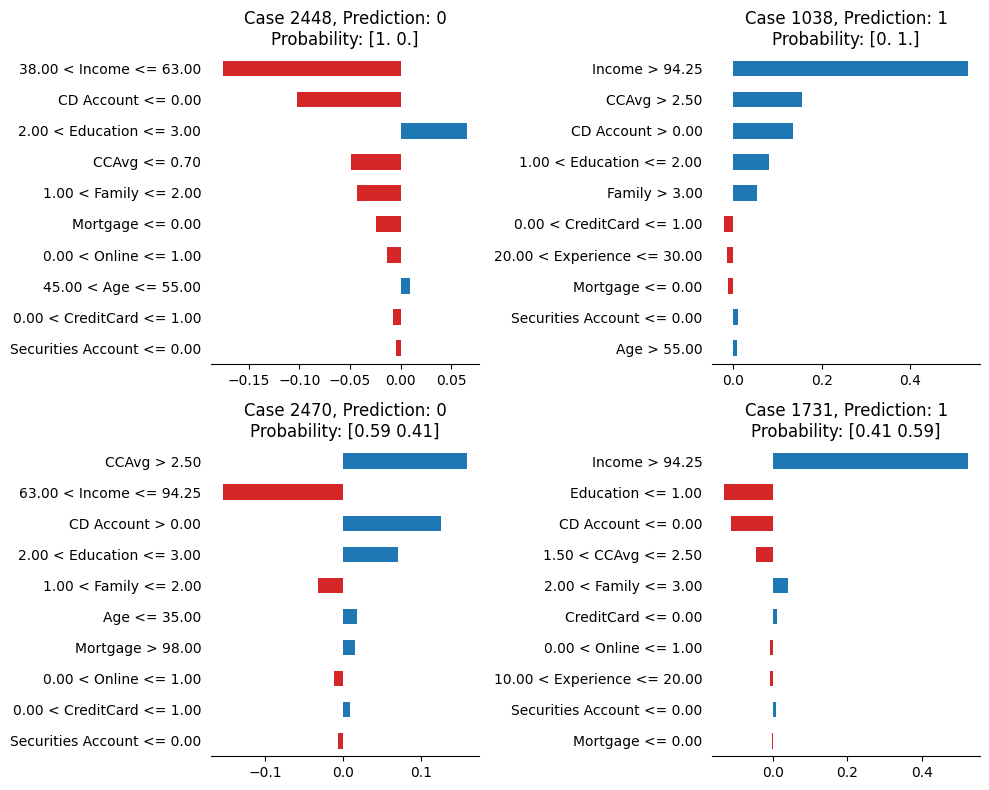

In [17]:
import warnings
warnings.simplefilter("ignore")
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
        feature_names=predictors, class_names=np.array([0, 1]),
        discretize_continuous=True)

def lime_plot(explainer, model, X, case, ax):
    x = X.loc[case].values
    exp = explainer.explain_instance(x, model.predict_proba, top_labels=2)
    pred = model.predict(x.reshape(1, -1))
    probs = model.predict_proba(x.reshape(1, -1))
    ax.set_title(f'Case {case}, Prediction: {pred[0]}\nProbability: {probs[0]}')
    explanation = exp.as_list(label=1)
    explanation = pd.Series([e[1] for e in explanation], index=[e[0] for e in explanation]).iloc[::-1]
    color = ['C0' if e > 0 else 'C3' for e in explanation]
    explanation.plot(kind='barh', ax=ax, color=color)
    ax.spines[['left', 'right', 'top']].set_visible(False)
    ax.yaxis.set_ticks_position('none')


test = X_holdout.values
i = np.random.randint(0, test.shape[0])
cases = [2448, 1038, 2470, 1731]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10, 8])
for case, ax in zip(cases, axes.flatten()):
    lime_plot(explainer, rf, X_holdout, case, ax)
plt.tight_layout()
plt.show()